# Predicting Cuphead Bosses from Keystroke Data

## 1. Introduction / The Dataset

According to Steam, I've spent 155.5 hours playing Cuphead (wow!). The game is essentially a series of unique boss battles, each demanding a completely different strategy and rhythm. So I thought it would be fun to see if my own unconscious gameplay patterns, like my button presses and my reliance on certain moves, are distinct enough for a machine to tell the bosses apart.

The data for this project is a **personal archive of my keystroke recordings from 240 fight attempts against four specific bosses (60 fights each)**: Cagney Carnation, Grim Matchstick, Baroness Von Bon Bon, and Glumstone the Giant.


### How the Data Was Obtained and Sampled

To capture this, I developed a custom Python application using `Tkinter` for the UI and `pynput` for keyboard listening. The tool used global hotkeys to precisely mark the start and end of each fight, ensuring a clean and consistent dataset.


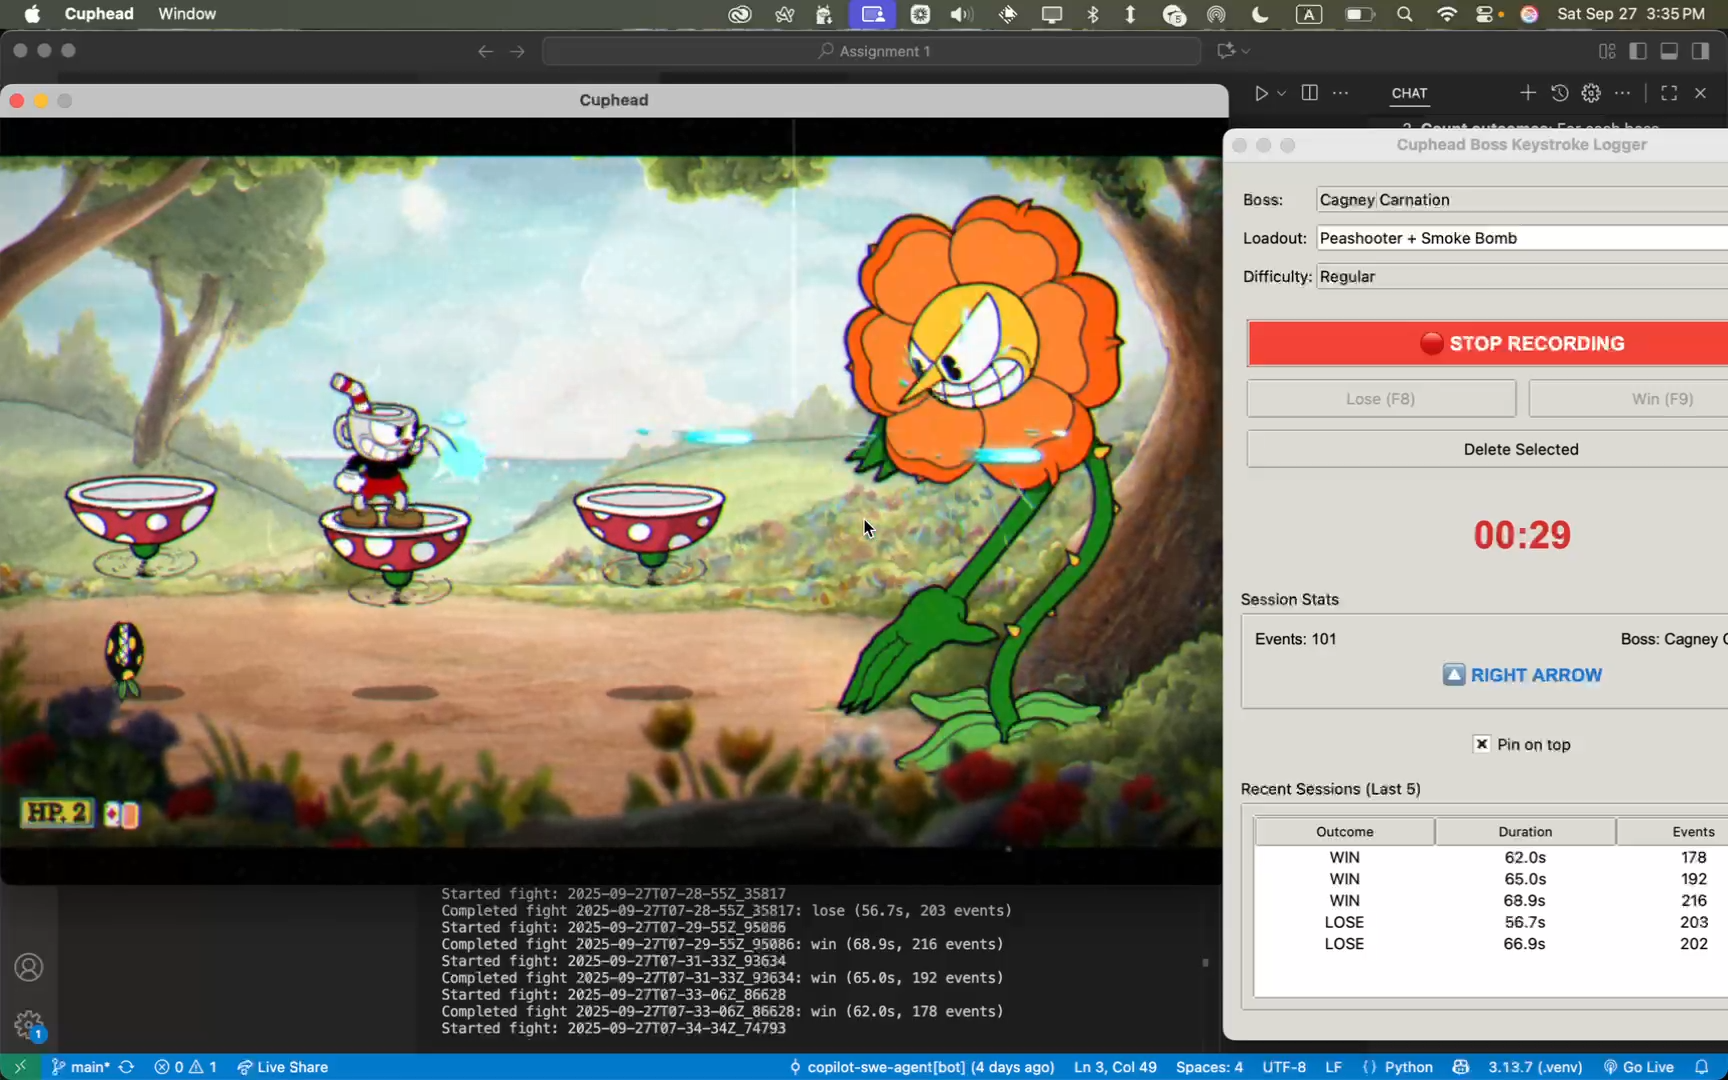

 Each session was saved as a JSON Lines (.jsonl) file containing metadata, a full stream of timestamped keydown and keyup events, and a final summary of the outcome and duration. As the data comes entirely from my own playtime, it represents a convenience sample. More details on the logger's design and data quality features can be found in Appendix A.

 [Keystorke logger code base (Github)](https://github.com/ddanakim0304/CS156-Assignment-1) - detailed code explanation in Appendix B


**Sample Log Structure:**

[View All the Raw Logs on GitHub](https://github.com/ddanakim0304/CS156-Assignment-1/blob/main/data/raw/2025-09-23T13-52-06Z_26962.jsonl)

In [85]:
{"meta": {"boss": "Cagney Carnation", "loadout": "Peashooter + Smoke Bomb", "difficulty": "Regular", "start_utc": "2025-09-23T13-52-06.960065+00:00"}}
{"event": "keydown", "key": "f", "t_ms": 1476}
{"event": "keydown", "key": "Key.space", "t_ms": 4038}
{"event": "keyup", "key": "Key.space", "t_ms": 4054}
{"summary": {"outcome": "win", "duration_ms": 74788, "end_utc": "2025-09-23T13:53:21.751994+00:00"}}

{'summary': {'outcome': 'win',
  'duration_ms': 74788,
  'end_utc': '2025-09-23T13:53:21.751994+00:00'}}

#### Data Collection Recording (Old UI - 1h 18 min)

https://www.loom.com/share/29298ba8cc3140d0a84c9be8ac7e7394


#### Data Collection Recording (Latest UI - 8 min)
https://www.loom.com/share/94c7d83c027349d9a0a2fc186096ca72?sid=ae4d6bcb-923f-463b-8225-b8fc977820b4

### 2. Loading the Raw Data

The raw `.jsonl` logs are just streams of events, a format that machine learning models can't digest. I need to transform this sequence into a structured tabular format, and a `pandas` DataFrame is the essential tool for this job. I chosese `pandas` because it provides the suitable data structure (DataFrame) and a toolkit of fast operations (.groupby, filtering, etc) that are the industry standard for cleaning and transforming data for machine learning.

#### Data Cleaning

1. Because I started and stopped the logger manually with a hotkey, there's a human-sized delay between when the fight actually starts on screen and when I hit the record button. The real fight doesn't begin until my first key press. So, I've adjusted all the timestamps to start at t_ms = 0 from the very first action in each log.

2. I also had to discard any accidental recordings. Sometimes I'd start the logger and stop it immediately. To deal with this, any fight lasting less than 5 seconds or with fewer than 10 key presses is deleted.

# Check this
3. Finally, to ensure my dataset is perfectly balanced for the classification task, I took a random sample of 60 fights for each of the four bosses



In [86]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import glob

# Import Machine Learning Libraries
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from matplotlib.colors import ListedColormap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


# Set a random seed for reproducibility of the sampling
np.random.seed(34)

In [87]:
# 1. Load All Raw Data
data_path = '../data/raw/*.jsonl'
files = glob.glob(data_path)
all_events_data = []

# Iterate through each file and extract event data
for file_path in files:
    with open(file_path, 'r') as f:
        # Read all lines from the file
        lines = f.readlines()
        if not lines: continue
        try:
            meta_data = json.loads(lines[0])['meta']
            fight_id = json.loads(lines[0])['fight_id']
            boss_name = meta_data.get('boss')
            for line in lines[1:-1]:
                event_data = json.loads(line)
                if 'event' in event_data:
                    all_events_data.append({
                        'fight_id': fight_id, 'boss': boss_name,
                        'event': event_data['event'], 'key': event_data['key'],
                        't_ms': event_data['t_ms']
                    })
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Skipping malformed file: {file_path}")

# Convert the list of event data into a DataFrame
raw_df = pd.DataFrame(all_events_data)
print(f"Loaded a total of {raw_df['fight_id'].nunique()} fights initially.")


# 2. Adjust Timestamps
# The real start time for each fight is the timestamp of the first key press.
# We subtract this from all timestamps in that fight to normalize them.
first_action_times = raw_df.groupby('fight_id')['t_ms'].transform('min')
clean_df = raw_df.copy()
clean_df['t_ms'] = clean_df['t_ms'] - first_action_times
print("Normalized all fight timestamps to start at t_ms = 0 from the first action.")


# 3. Filter Out Accidental Recordings
# Calculate the duration and event count for each fight after timestamp adjustment
fight_stats = clean_df.groupby('fight_id')['t_ms'].agg(
    event_count='count', 
    duration_ms='max'
)
# Identify the IDs of fights that are long enough and have enough events
valid_fight_ids = fight_stats[
    (fight_stats['event_count'] >= 10) & 
    (fight_stats['duration_ms'] >= 5000)
].index
clean_df = clean_df[clean_df['fight_id'].isin(valid_fight_ids)]
print(f"Filtered down to {len(valid_fight_ids)} valid fights (>=10 events and >=10s duration).")


# Randomly Sample 60 Fights
all_sampled_ids = []

# Get unique fight IDs along with their corresponding boss names
valid_fights_with_boss = clean_df[['fight_id', 'boss']].drop_duplicates()

for boss_name in valid_fights_with_boss['boss'].unique():
    # Get all valid fight IDs for the current boss
    boss_fight_ids = valid_fights_with_boss[valid_fights_with_boss['boss'] == boss_name]['fight_id'].unique()
    
    # Print the count before sampling
    total_fights_for_boss = len(boss_fight_ids)
    print(f"- {boss_name}: 60 fights chosen out of {total_fights_for_boss} fights")
    
    # Randomly choose 60 IDs from this boss's pool
    sampled_boss_ids = np.random.choice(boss_fight_ids, size=60, replace=False)
    
    # Add these sampled IDs to our master list
    all_sampled_ids.extend(sampled_boss_ids)

# Filter the main DataFrame to keep only the 240 sampled fights
final_df = clean_df[clean_df['fight_id'].isin(all_sampled_ids)].reset_index(drop=True)

print(f"\nFinal balanced dataset contains {final_df['fight_id'].nunique()} fights.")
print("Final clean DataFrame ready for feature engineering:")
final_df.head()

Loaded a total of 278 fights initially.
Normalized all fight timestamps to start at t_ms = 0 from the first action.
Filtered down to 277 valid fights (>=10 events and >=10s duration).
- Glumstone the Giant: 60 fights chosen out of 82 fights
- Baroness Von Bon Bon: 60 fights chosen out of 60 fights
- Cagney Carnation: 60 fights chosen out of 74 fights
- Grim Matchstick: 60 fights chosen out of 61 fights

Final balanced dataset contains 240 fights.
Final clean DataFrame ready for feature engineering:


fight_id                 boss    event       key  t_ms
0  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown         f     0
1  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown  Key.down    45
2  2025-09-24T10-17-07Z_27194  Glumstone the Giant    keyup  Key.down   332
3  2025-09-24T10-17-07Z_27194  Glumstone the Giant    keyup         f   403
4  2025-09-24T10-17-07Z_27194  Glumstone the Giant  keydown  Key.down   543

### 3. Pre-processing and Feature Engineering

With the clean event data loaded, the next step is to transform it into a machine-learnable feature matrix. Before boiling everything down to a few numbers, I wanted to actually *see* what the gameplay rhythm looks like. To do this, I created a Keystroke Timeline plot, which visualizes every single key press in a fight on a timeline, with the length of each bar showing exactly how long I held the button down.

To get the clearest picture of a complete strategy for each boss, I selected my longest successful ('win') attempt for this visualization. For Glumstone the Giant, where I didn't have a 'win' log in my sampled data, I chose my longest attempt to see the pattern.

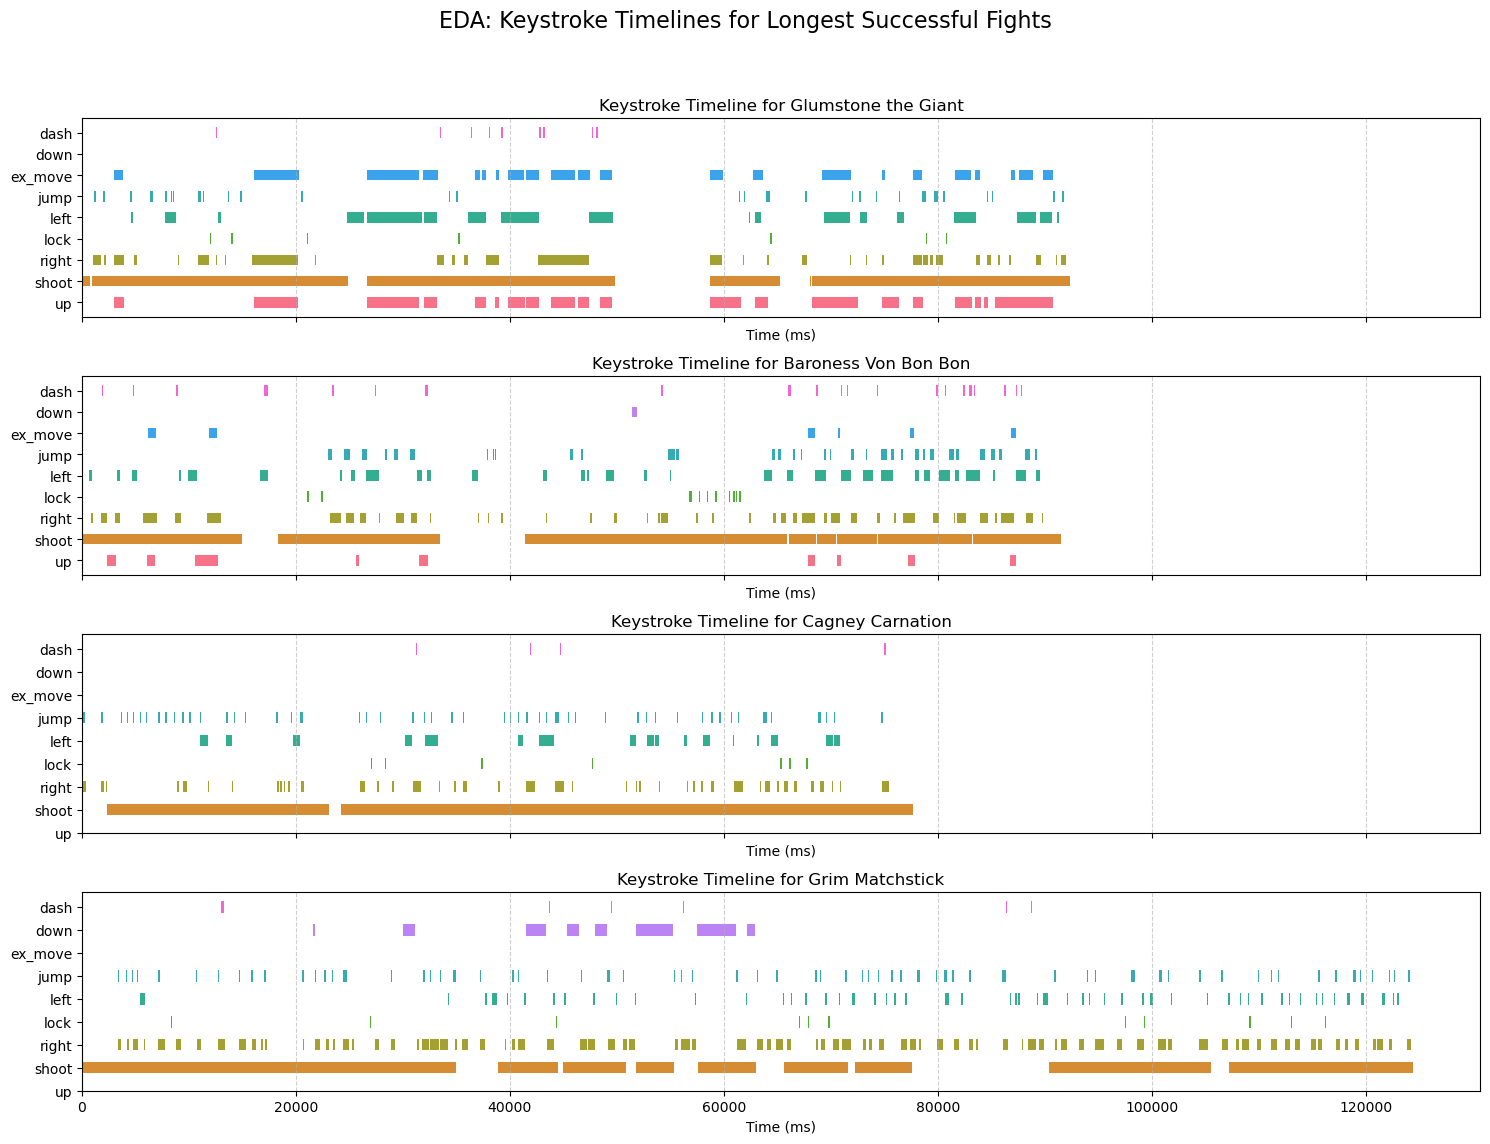

In [88]:
# 1. Pre-processing: Standardize Action Names
key_mapping = {
    'Key.space': 'jump', 'f': 'shoot', 'd': 'dash', 'x': 'ex_move',
    'a': 'lock', 'Key.up': 'up', 'Key.down': 'down', 'Key.left': 'left', 'Key.right': 'right'
}
processed_df = final_df.copy()
processed_df['action'] = processed_df['key'].map(key_mapping)
# Drop any events that weren't in the mapping
processed_df.dropna(subset=['action'], inplace=True)


# EDA: Visualizing the Raw Keystroke Timeline

# Gather fight outcomes and durations from the summary lines
fight_outcomes = {}
for file_path in glob.glob('../data/raw/*.jsonl'):
    fight_id = file_path.split('/')[-1].replace('.jsonl', '')
    with open(file_path, 'r') as f:
        try:
            last_line = f.readlines()[-1]
            summary = json.loads(last_line)['summary']
            fight_outcomes[fight_id] = {
                "outcome": summary.get('outcome'),
                "duration_ms": summary.get('duration_ms')
            }
        except (IndexError, json.JSONDecodeError, KeyError):
            continue

outcomes_df = pd.DataFrame.from_dict(fight_outcomes, orient='index').reset_index().rename(columns={'index': 'fight_id'})

# Select the specific fight IDs for visualization
fight_ids_for_plot = []
boss_names = processed_df['boss'].unique()

for boss in boss_names:
    # Get all fight IDs for the current boss from our sampled dataset
    boss_fight_ids = processed_df[processed_df['boss'] == boss]['fight_id'].unique()
    
    # Merge with outcomes and durations
    boss_fights_df = outcomes_df[outcomes_df['fight_id'].isin(boss_fight_ids)]
    
    # Try to find the longest 'win'
    win_fights = boss_fights_df[boss_fights_df['outcome'] == 'win']
    
    if not win_fights.empty:
        # If there are wins, get the ID of the longest one
        longest_win_id = win_fights.sort_values('duration_ms', ascending=False).iloc[0]['fight_id']
        fight_ids_for_plot.append(longest_win_id)
    else:
        # If no wins, get the ID of the longest fight overall for that boss
        longest_fight_id = boss_fights_df.sort_values('duration_ms', ascending=False).iloc[0]['fight_id']
        fight_ids_for_plot.append(longest_fight_id)

# Prepare Color Mapping for Actions
all_possible_actions = sorted(processed_df['action'].unique(), reverse=True)
palette = sns.color_palette("husl", len(all_possible_actions))
global_color_map = dict(zip(all_possible_actions, palette))
global_action_map = {action: i for i, action in enumerate(all_possible_actions)}

# Plotting Function and Execution
def plot_fight_timeline(df, fight_id, ax, action_order, action_map, color_map):
    """Generates a Gantt-style chart with a consistent y-axis."""
    fight_data = df[df['fight_id'] == fight_id].copy()
    
    boss_name = fight_data['boss'].iloc[0] # Get boss name early
    ax.set_title(f"Keystroke Timeline for {boss_name}")
    
    # Calculate durations for this fight
    downs = fight_data[fight_data['event'] == 'keydown'].copy()
    ups = fight_data[fight_data['event'] == 'keyup'].copy()
    downs['press_num'] = downs.groupby(['fight_id', 'action']).cumcount()
    ups['press_num'] = ups.groupby(['fight_id', 'action']).cumcount()
    merged = pd.merge(downs, ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_start', '_end'))
    durations = merged[merged['t_ms_end'] > merged['t_ms_start']].copy()
    
    # Only try to plot if there are valid durations to show
    if not durations.empty:
        durations['duration'] = durations['t_ms_end'] - durations['t_ms_start']
        bar_colors = durations['action'].map(color_map)
        ax.barh(y=durations['action'].map(action_map), 
                left=durations['t_ms_start'], 
                width=durations['duration'], 
                height=0.5,
                color=bar_colors)
            
    # Set consistent y-axis
    ax.set_yticks(range(len(action_order)))
    ax.set_yticklabels(action_order)
    ax.set_xlabel("Time (ms)")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

# Create subplots for each selected fight
fig, axes = plt.subplots(len(fight_ids_for_plot), 1, figsize=(15, 12), sharex=True)
fig.suptitle('EDA: Keystroke Timelines for Longest Successful Fights', fontsize=16)

for i, fight_id in enumerate(fight_ids_for_plot):
    plot_fight_timeline(processed_df, fight_id, axes[i], all_possible_actions, global_action_map, global_color_map)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analysis of Single-Fight Timelines
These timelines offer a direct visual confirmation of my hypothesis. Grim Matchstick is a chaotic rhythm of extremely short, frequent taps on `'jump'` and `'left'`/`'right'`, reflecting constant platforming.

<img src="../photos/Grim.jpg" width="480">


Conversely, Glumstone the Giant shows long holds on `'up'` and `'shoot'` (the boss location is always high than the character). This proves that press duration and frequency are distinct.

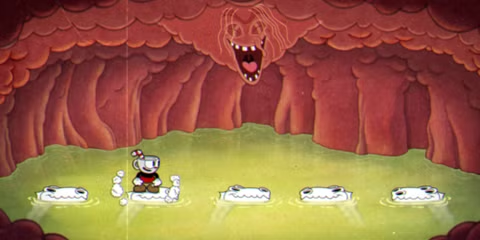


But how do we generalize this to all data? This is only the the longest fight among 60 fights.

### Aggregated Heatmap

To see if these single-fight patterns hold true across the entire dataset, I aggregated the timing data into a heatmap. This visualizes the average press duration for every action against every boss. I'm using a logarithmic color scale to handle the huge variance between quick taps and long holds, which confirms that press duration is a generalizable feature for my models.

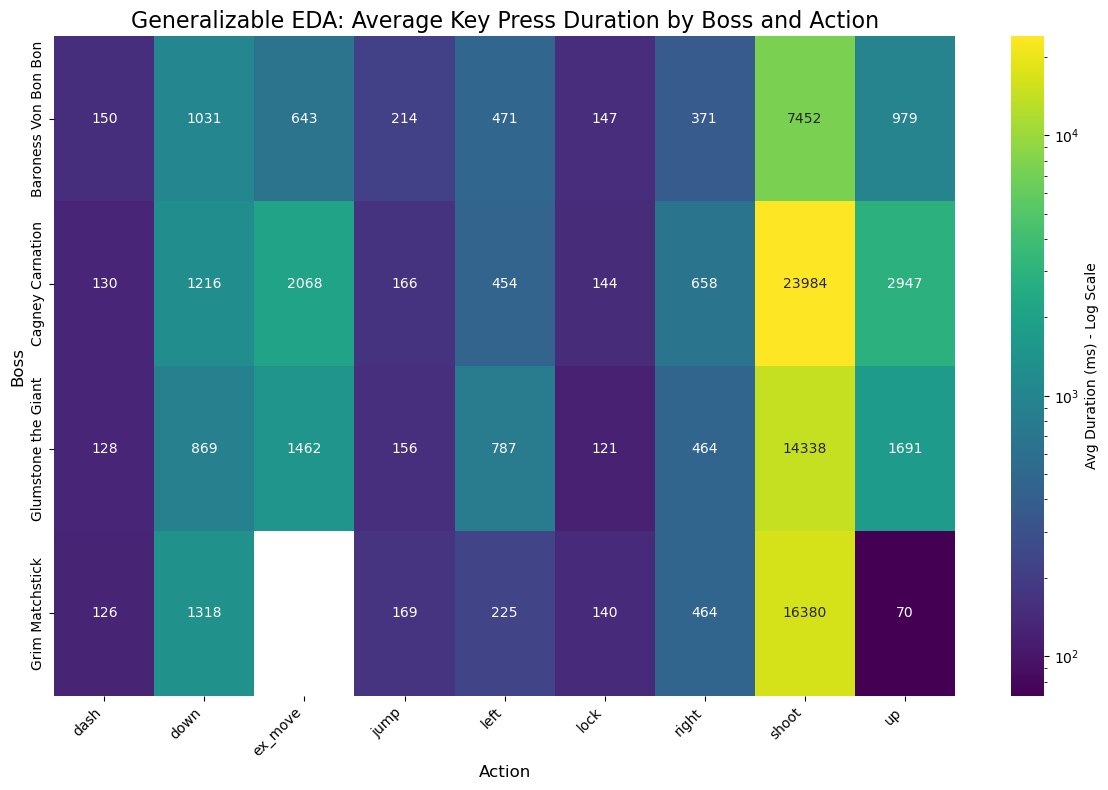

In [89]:


# EDA: Generalized Heatmap of Press Durations

# calculate the press durations for all fights in our dataset
all_downs = processed_df[processed_df['event'] == 'keydown'].copy()
all_ups = processed_df[processed_df['event'] == 'keyup'].copy()

# Group by fight_id and action to correctly match each press to its release
all_downs['press_num'] = all_downs.groupby(['fight_id', 'action']).cumcount()
all_ups['press_num'] = all_ups.groupby(['fight_id', 'action']).cumcount()

all_merged = pd.merge(all_downs, all_ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_down', '_up'))
all_merged['duration_ms'] = all_merged['t_ms_up'] - all_merged['t_ms_down']
all_durations = all_merged[all_merged['duration_ms'] >= 0]

# Create a pivot table to get the average duration for each (Boss, Action) pair
pivot_df = all_durations.groupby(['boss', 'action'])['duration_ms'].mean().unstack()

# 3. Plot the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_df, 
    annot=True,           # Show the actual numbers in each cell
    fmt=".0f",            # Format numbers as integers
    cmap="viridis",       # color map
    norm=LogNorm(),       # Use a logarithmic scale for the colors
    cbar_kws={'label': 'Avg Duration (ms) - Log Scale'} # Label the color bar
)

plt.title('Generalizable EDA: Average Key Press Duration by Boss and Action', fontsize=16)
plt.xlabel('Action', fontsize=12)
plt.ylabel('Boss', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Analysis of Generalized Patterns
This heatmap confirms the trends, like Grim Matchstick's `up` key is a uniquely short and `shoot` key is long compared to other bosses. 

However, relying solely on this grand average is deceptive, as it's skewed by the wide variance in my fight lengths and compresses the entire distribution of press times into a single number. To build a robust model, I need to engineer features that capture the gameplay *consistency* and variability within each fight, not just the overall mean.

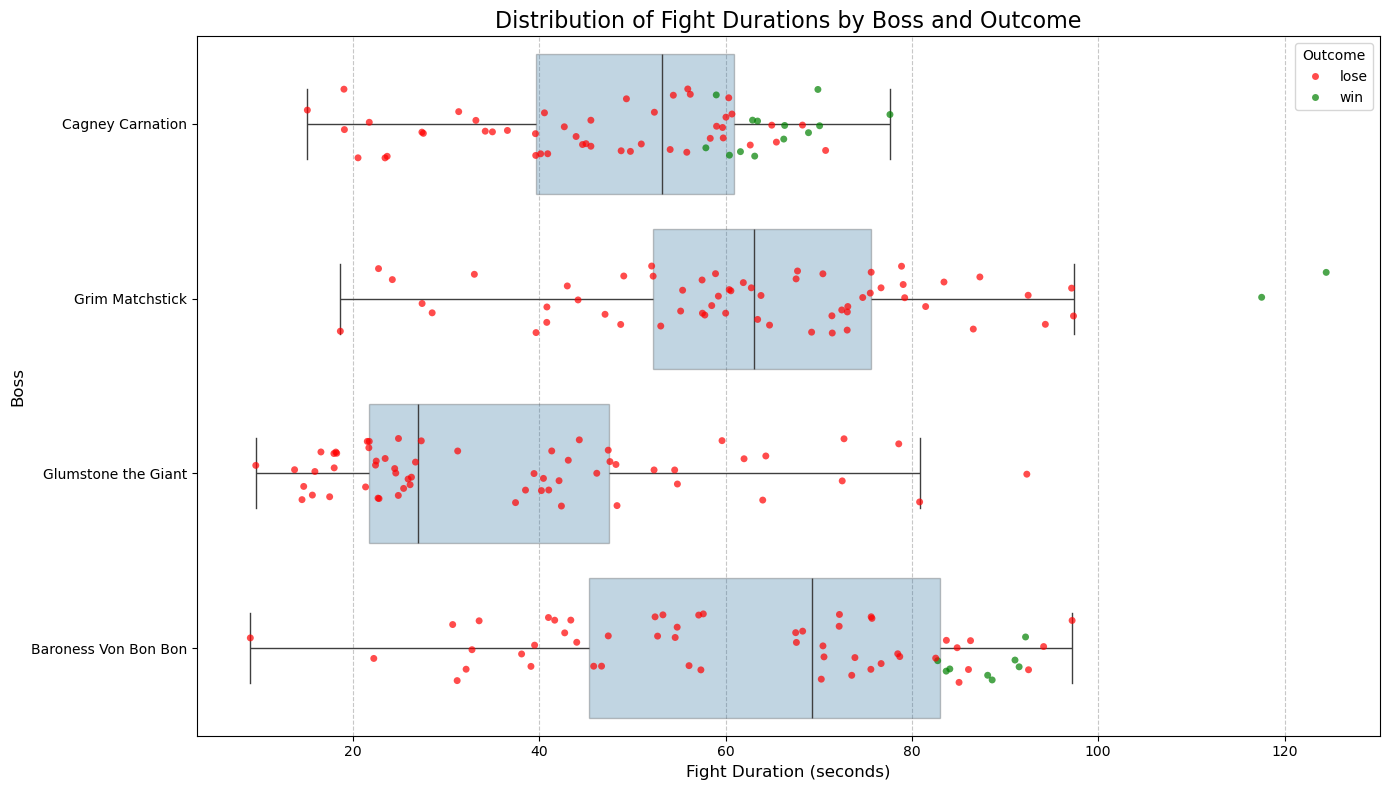

In [90]:
# EDA: Visualizing Fight Duration Distribution by Outcome
fight_summaries_for_plot = final_df.groupby('fight_id').agg(
    duration_ms=('t_ms', 'max'),
    boss=('boss', 'first')
).reset_index()

# Convert duration to seconds
fight_summaries_for_plot['duration_s'] = fight_summaries_for_plot['duration_ms'] / 1000

# Merge with outcomes to get the outcome for each fight
plot_data = pd.merge(fight_summaries_for_plot, outcomes_df, on='fight_id', suffixes=('', '_from_summary'))

plt.figure(figsize=(14, 8))

# Define a specific color palette for clarity
outcome_palette = {'win': 'green', 'lose': 'red'}

# draw the boxplots to show the summary statistics
sns.boxplot(
    data=plot_data, 
    y='boss', 
    x='duration_s', 
    orient='h',
    showfliers=False,  # Hide outlier points from the boxplot itself
    boxprops=dict(alpha=.3) # Make boxes slightly transparent
)

# overlay the stripplot to show every individual fight
sns.stripplot(
    data=plot_data, 
    y='boss', 
    x='duration_s', 
    hue='outcome',
    orient='h',
    jitter=0.2,
    alpha=0.7,
    palette=outcome_palette
)

plt.title('Distribution of Fight Durations by Boss and Outcome', fontsize=16)
plt.xlabel('Fight Duration (seconds)', fontsize=12)
plt.ylabel('Boss', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

### EDA Takeaway and Feature Engineering

The exploratory data analysis reveals significant variance in fight durations, presenting a challenge for feature engineering. 

A suggestion from class was to slice the timeline into fixed chunks, but I didn't implement it since it would create misaligned feature vectors from fights of different lengths and pose a high risk of overfitting.

Therefore, I adopted a strategy of engineering statistical summaries for each entire fight, aiming to capture not only average behaviors but also the gameplay *variability* and *consistency* identified during EDA.

| Feature Strategy | Pros | Cons | Status | How Cons are Addressed |
| :--- | :--- | :--- | :--- | :--- |
| **Fixed Time Slices** | - Attempts to capture temporal evolution of gameplay. | - Creates sparse/misaligned vectors from variable-length data.<br>- High risk of overfitting due to feature explosion. | **Rejected** | N/A |
| **Proportional Time Slicing** | - Solves the variable-length issue by dividing fights into percentage-based chunks (ㄷㅌ. 10 chunks of 10% each). | - Boss phases are triggered by damage, not time. A 10% time slice might be phase 1 in a long fight but phase 2 in a short one, making the features non-comparable. | **Rejected** | N/A |
| **Recurrent Neural Networks (RNN/LSTM)**| - The most powerful method for modeling raw sequential data directly. | - High implementation complexity (padding, vectorization).<br>- Prone to overfitting on smaller datasets (240 samples). | **Rejected (For this assignment)** | N/A (A great candidate for future work with more data. |
| **Aggregate Statistical Features** | - Directly captures variability (`std`, `median`).<br>- Creates a dense, fixed-size vector for every fight.<br>- Robust to outliers and varying fight lengths. | - Loses all information about the **sequence** of actions (ex. is a `dash` usually preceded by a `jump`?). | **Accepted (Foundational)**| This con is directly complemented by using **N-gram Features**. |
| **N-gram Sequence Features** | - Captures the order and rhythm of common action combos.<br>- Adds crucial sequential context to the model. | - Loses all precise **timing** information (e.g., the duration of the presses or the time between them). | **Accepted (Enrichment)**| This con is directly complemented by the **Aggregate Statistical Features**. |

### Aggregate Statistical Features
This code builds my foundational feature set by calculating three distinct categories of statistics for each fight:

1.  Actions Per Minute (APM) and the percentage of total presses for each specific action (ex. `pct_jump`).
2.  The `mean`, `std`, `median`, `min`, and `max` of all press durations to quantify overall gameplay consistency and variability.
3.  The `mean` and `std` of press durations for *each individual action* (ex. `jump_duration_mean`)

In [91]:
# Calculate Press Durations for all fights
def calculate_all_press_durations(df):
    """Matches every keydown to its corresponding keyup to get press durations for all fights."""
    downs = df[df['event'] == 'keydown'].copy()
    ups = df[df['event'] == 'keyup'].copy()
    
    # Create a unique ID for each press of a specific action within a fight
    downs['press_num'] = downs.groupby(['fight_id', 'action']).cumcount()
    ups['press_num'] = ups.groupby(['fight_id', 'action']).cumcount()
    
    # Merge them together to align the start and end time of each press
    merged = pd.merge(downs, ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_down', '_up'))
    
    # Calculate duration and filter out any potential negative durations from data errors
    merged['duration_ms'] = merged['t_ms_up'] - merged['t_ms_down']
    return merged[merged['duration_ms'] >= 0][['fight_id', 'action', 'duration_ms']]

press_durations_df = calculate_all_press_durations(processed_df)


# Engineer the Foundational Feature Set

# Part A: Pace & Frequency Features (from keydown events)
keydowns = processed_df[processed_df['event'] == 'keydown']
fight_summaries = keydowns.groupby('fight_id').agg(
    duration_ms=('t_ms', 'max'),
    event_count=('t_ms', 'count'),
    boss=('boss', 'first')
)
fight_summaries['apm'] = (fight_summaries['event_count'] / (fight_summaries['duration_ms'] / 1000.0)) * 60
action_percentages = keydowns.groupby(['fight_id', 'action']).size().unstack(fill_value=0).div(fight_summaries['event_count'], axis=0).add_prefix('pct_')

# Part B: Overall Rhythm Features (capturing variability)
overall_duration_stats = press_durations_df.groupby('fight_id')['duration_ms'].agg(
    ['mean', 'std', 'median', 'min', 'max']
).add_prefix('overall_duration_')

# Part C: Action-Specific Timing Features
action_specific_stats = press_durations_df.groupby(['fight_id', 'action'])['duration_ms'].agg(['mean', 'std']).unstack().fillna(0)
# Flatten the multi-level column names (('mean', 'jump') -> 'mean_jump')
action_specific_stats.columns = ['_'.join(col).strip() for col in action_specific_stats.columns.values]

# Combine all foundational features into a single DataFrame
agg_features = fight_summaries.join(action_percentages).join(overall_duration_stats).join(action_specific_stats).fillna(0)

# Separate features (X) from the target variable (y)
X_agg = agg_features.drop(columns=['boss', 'duration_ms', 'event_count'])
y = agg_features['boss']

print("Successfully created the foundational feature set.")
print(f"Shape of feature matrix (X_agg): {X_agg.shape}")
print("\nFirst 5 rows of the feature matrix:")
X_agg.head()

Successfully created the foundational feature set.
Shape of feature matrix (X_agg): (240, 33)

First 5 rows of the feature matrix:


apm  pct_dash  pct_down  pct_ex_move  \
fight_id                                                                  
2025-09-23T13-51-00Z_60041  114.321347  0.018182  0.000000     0.018182   
2025-09-23T13-53-53Z_33477  115.224478  0.042017  0.000000     0.000000   
2025-09-23T13-55-01Z_1585   106.557652  0.047170  0.000000     0.009434   
2025-09-23T13-57-05Z_25486  102.404096  0.031250  0.000000     0.000000   
2025-09-23T14-02-29Z_49949  124.101400  0.060976  0.036585     0.000000   

                            pct_jump  pct_left  pct_lock  pct_right  \
fight_id                                                              
2025-09-23T13-51-00Z_60041  0.400000  0.172727  0.036364   0.309091   
2025-09-23T13-53-53Z_33477  0.403361  0.184874  0.075630   0.285714   
2025-09-23T13-55-01Z_1585   0.377358  0.150943  0.075472   0.301887   
2025-09-23T13-57-05Z_25486  0.437500  0.132812  0.054688   0.328125   
2025-09-23T14-02-29Z_49949  0.353659  0.109756  0.036585   0.390244   

                            pct_shoot    pct_up  ...  mean_up   std_dash  \
fight_id                                         ...                       
2025-09-23T13-51-00Z_60041   0.027273  0.018182  ...   1711.0   0.000000   
2025-09-23T13-53-53Z_33477   0.008403  0.000000  ...      0.0   6.685806   
2025-09-23T13-55-01Z_1585    0.018868  0.018868  ...    333.0  20.329781   
2025-09-23T13-57-05Z_25486   0.015625  0.000000  ...      0.0   4.830459   
2025-09-23T14-02-29Z_49949   0.012195  0.000000  ...      0.0  25.351529   

                              std_down  std_ex_move   std_jump    std_left  \
fight_id                                                                     
2025-09-23T13-51-00Z_60041    0.000000   1195.01046  63.923063  189.790312   
2025-09-23T13-53-53Z_33477    0.000000      0.00000  51.093156  271.200633   
2025-09-23T13-55-01Z_1585     0.000000      0.00000  36.973232  276.202945   
2025-09-23T13-57-05Z_25486    0.000000      0.00000  59.789476  316.814719   
2025-09-23T14-02-29Z_49949  557.311702      0.00000  53.159788  121.180421   

                             std_lock   std_right     std_shoot      std_up  
fight_id                                                                     
2025-09-23T13-51-00Z_60041  19.131126  455.944910  28987.901103  547.300649  
2025-09-23T13-53-53Z_33477  11.938500  246.356487      0.000000    0.000000  
2025-09-23T13-55-01Z_1585   14.267220  215.707517  41828.194534   25.455844  
2025-09-23T13-57-05Z_25486  25.967012  219.255757  23143.604948    0.000000  
2025-09-23T14-02-29Z_49949  17.521415  301.333428      0.000000    0.000000  

[5 rows x 33 columns]

### N-gram
While my foundational feature set (`X_agg`) captures the *what* and *how* of my gameplay, it completely ignores the *order*. It doesn't know if a `'dash'` is usually preceded by a `'jump'`, which is a critical piece of the gameplay rhythm. To solve this, I'm borrowing a technique from text analysis called **N-grams**.

To capture only the rapid, reflexive action patterns, I only considered actions that occur within 1 second (1000ms) of each other to be part of the same combo. If there's a longer pause in my gameplay, I insert a "break" in the action sequence. This prevents the model from learning meaningless long-distance associations and ensures the resulting N-gram features represent genuine, rapid-fire gameplay combos.

#### Mathematical Explanation & Pseudocode

An N-gram is a contiguous sequence of *n* items from a given sample of text or sequence. For a sequence of actions $A = (a_1, a_2, ..., a_T)$, a bigram (2-gram) is a pair $(a_i, a_{i+1})$. The process of creating N-gram features involves two main steps:

1.  **Vocabulary Creation:** The algorithm first scans the entire corpus of action sequences (all 240 fights) to identify all unique N-grams (e.g., `'jump dash'`, `'shoot lock'`). The top *k* most frequent N-grams are selected to form the feature "vocabulary," $V = \{ngram_1, ngram_2, ..., ngram_k\}$.

2.  **Vectorization:** For each individual fight, the algorithm creates a feature vector $\mathbf{x}_{ngram}$ of length *k*. Each element $j$ in this vector, $\mathbf{x}_{ngram, j}$, is the count of how many times $ngram_j$ from the vocabulary appears in that fight's action sequence. This is a Term Frequency (TF) representation.

Final model has been trained on the full original dataset.

Found 28 new log files for final validation.


/var/folders/_2/1tb09tx55zx8v2lc5wd2_8400000gn/T/ipykernel_14726/1051665240.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_fight_actions_str = new_keydowns.groupby('fight_id').apply(create_combo_sentences)


AttributeError: 'Series' object has no attribute 'nonzero'

## Analysis Plan

The objective is a **multi-class classification** problem: to predict the boss from my keystroke data.

## Data Splitting Strategy

To get a realistic measure of performance, I must account for the natural variation in my playstyle between sessions (different days). A standard random split would leak this session-specific information, resulting in an overly optimistic model score.

Therefore, I am implementing the group-aware splitting strategy using GroupKFold. This ensures that all fights from a single play session (defined by the date) are kept together in either the training set or the testing set, never splitting groups across both. This forces the model to generalize patterns independent of session-specific timing quirks.

To determine the most reliable validation strategy for my dataset, I will experiment with two different group-aware cross-validation methods. This allows me to directly test the trade-off between the bias and variance of my performance estimate.

1.  **5-Fold GroupKFold:** This is the standard approach. Since it has less number of groups than the LOGO, it has a more stable but slightly more biased performance estimate.
2.  **Leave-One-Group-Out (LOGO):** This method uses the maximum amount of training data in each fold, resulting in a low-bias estimate of model performance. However, because each test set is only a single play session, the final scores can have high variance if any one session is an anomaly.

By comparing the results from both strategies, I can get a more complete picture of my model's true generalization capability. The code below prepares the group identifier and visualizes how each strategy allocates data into training and testing sets for each cross-validation fold.

Identified 8 unique play sessions (groups).
Unique session IDs: ['2025-09-23' '2025-09-24' '2025-09-26' '2025-09-27' '2025-09-29'
 '2025-10-04' '2025-10-08' '2025-10-14']


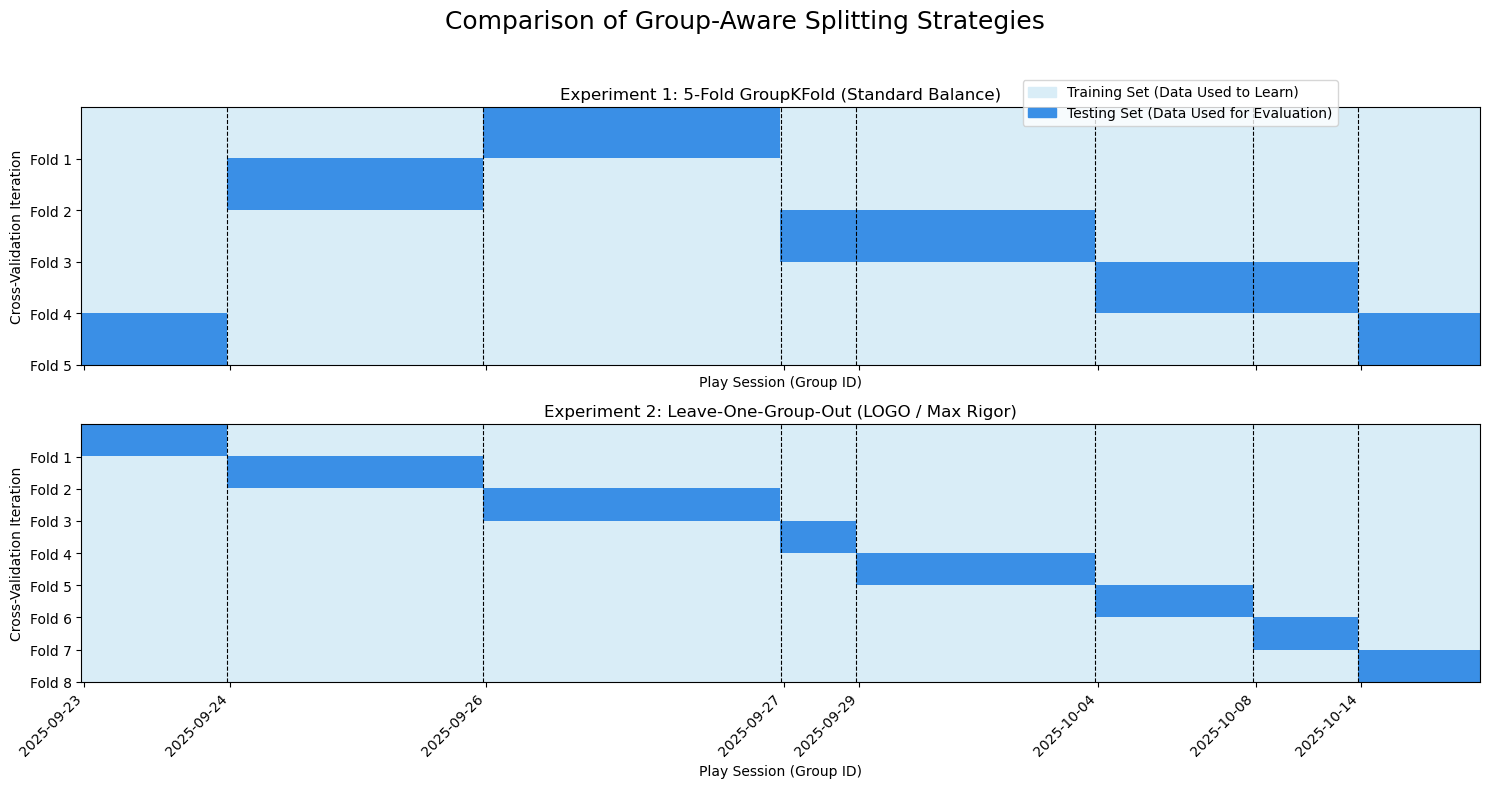

In [ ]:
# Create the Group Identifier 
# Each fight_id corresponds to a unique play session (group).
groups = y.index.str[:10]  
unique_groups = np.unique(groups)
n_groups = len(unique_groups)

print(f"Identified {n_groups} unique play sessions (groups).")
print(f"Unique session IDs: {unique_groups}")


# Define the Two Splitting Strategies
cv_5fold = GroupKFold(n_splits=5)
cv_logo = LeaveOneGroupOut()

# Visualization of the Splits
def visualize_splits(cv_strategy, X, y, groups, ax, strategy_name):
    """Draws a heatmap showing which samples fall into which train/test set for each fold."""
    # This visualization technique is excellent for explaining cross-validation logic.
    
    # Generate the indices for all folds
    folds = list(cv_strategy.split(X, y, groups))
    n_splits = len(folds)
    
    # Create a 2D array representing the data splits (0: Training, 1: Testing)
    indices = np.arange(len(X))
    split_matrix = np.full((n_splits, len(X)), 0)
    
    for i, (train_idx, test_idx) in enumerate(folds):
        # Mark test samples as 1
        split_matrix[i, test_idx] = 1 

    # Plot the heatmap
    cmap_custom = ListedColormap(['#d9edf7', '#3a8fe6']) # Light Blue for Train, Dark Blue for Test
    ax.imshow(split_matrix, aspect='auto', interpolation='nearest', cmap=cmap_custom)
    
    # Label the groups on the x-axis
    ax.set_xticks(np.unique(groups, return_index=True)[1])
    ax.set_xticklabels(unique_groups, rotation=45, ha='right')

    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f"Fold {i+1}" for i in range(n_splits)])
    
    ax.set_title(strategy_name)
    ax.set_ylabel('Cross-Validation Iteration')
    ax.set_xlabel('Play Session (Group ID)')

    # Draw lines to indicate group boundaries
    group_boundaries = np.where(groups[:-1] != groups[1:])[0]
    for x in group_boundaries:
        ax.axvline(x=x + 0.5, color='black', linewidth=0.8, linestyle='--')

fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
fig.suptitle('Comparison of Group-Aware Splitting Strategies', fontsize=18)

# Visualize 5-Fold Split
visualize_splits(cv_5fold, X_agg, y, groups, axes[0], "Experiment 1: 5-Fold GroupKFold (Standard Balance)")
# Visualize LOGO Split
visualize_splits(cv_logo, X_agg, y, groups, axes[1], "Experiment 2: Leave-One-Group-Out (LOGO / Max Rigor)")

train_patch = mpatches.Patch(color='#d9edf7', label='Training Set (Data Used to Learn)')
test_patch = mpatches.Patch(color='#3a8fe6', label='Testing Set (Data Used for Evaluation)')
fig.legend(handles=[train_patch, test_patch], loc='upper right', bbox_to_anchor=(0.9, 0.9))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 5. Model Selection and Mathematical Underpinnings

I have selected two models for comparison: a simple linear baseline (**Multinomial Logistic Regression**), and a non-linear ensemble model (**XGBoost Classifier**). I selected Multinomial Logistic Regression as an interpretable baseline to determine if a simple linear relationship exists between my gameplay features and the boss classes. In contrast, I chose the XGBoost classifier, a non-linear model, to test if there are more complex, interacting patterns in the data that the linear baseline cannot capture.

I will train both of these models on my foundational (`X_agg`) and enriched (`X_enriched`) feature sets, evaluating them with both the 5-Fold and LOGO cross-validation strategies, in order to determine the best combination of features, splitting method, and models for this classification task

### Mathematical Explanation

#### Multinomial Logistic Regression
*   **How it Works (Decision Rule):** Logistic Regression learns a linear decision boundary for each class. For an input sample $\mathbf{x}$, it computes a raw score (logit) for each class $k$ using a unique set of weights $\mathbf{w}_k$ and bias $b_k$.
    $$ z_k = \mathbf{w}_k^T \mathbf{x} + b_k $$
    These scores are then passed through a **softmax function** to produce a probability distribution across all classes. The model predicts the class with the highest probability.

*   **Objective and Optimization:** The model's goal is to find the optimal weights and biases that minimize the **Cross-Entropy Loss**. While `sklearn` uses the efficient L-BFGS solver, the pseudocode below illustrates the core iterative logic using the more intuitive Gradient Descent algorithm. In each step, it calculates how "wrong" its predictions are (the gradient) and nudges the weights in the direction that reduces this error.

*   **Regularization:** To prevent overfitting, L2 regularization is included in the gradient update step. This adds a penalty proportional to the size of the weights, controlled by `lambda` (which is related to the inverse of the `C` hyperparameter in `scikit-learn`), encouraging the model to learn simpler, more generalizable patterns.

#### XGBoost (eXtreme Gradient Boosting)

*   **How it Works (Decision Rule):** XGBoost is an ensemble of decision trees built sequentially. It starts with a base prediction and then adds a new tree in each iteration. Each new tree is specifically trained to predict and correct the *residual errors* of the ensemble of all preceding trees. The final prediction for a sample is the sum of the predictions from all the individual trees in the ensemble.

*   **Objective Function (Loss):** XGBoost minimizes a more complex objective function that includes both a loss term and a regularization term. The regularization term, $\Omega$, is what makes XGBoost so effective at controlling overfitting. The objective at step $t$ is:
    $$ \text{Obj}^{(t)} = \sum_{i=1}^{n} l(y_i, \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i)) + \Omega(f_t) \quad \text{where} \quad \Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2 $$
    Here, $l$ is the loss function, $f_t$ is the new tree, $T$ is the number of leaves in the tree, and $w_j$ is the score of the j-th leaf.

*   **Optimization & Regularization:** XGBoost uses a second-order Taylor approximation of the loss function to efficiently find the optimal leaf scores ($w_j$). The tree structure itself is built greedily, finding the best split at each node to maximize the reduction in the objective function. Regularization is controlled by several key hyperparameters:
    *   `n_estimators`: The total number of trees to build.
    *   `max_depth`: Controls the complexity of individual trees.
    *   `learning_rate` (eta): Shrinks the contribution of each new tree, a crucial technique to prevent overfitting.
    *   `gamma` and `lambda`: Directly control the penalties for tree complexity ($T$) and leaf score magnitudes ($w_j^2$) from the objective function.


*   **The `scikit-learn` Pipeline:** In practice, pre-processing steps like scaling and the model itself are bundled together into a `Pipeline` object. The reason for this is to prevent **data leakage** during cross-validation. A pipeline ensures that the `StandardScaler` is fitted *only* on the training data for each fold, and then that same fitted scaler is used to transform the validation data. This correctly simulates how the model would perform on truly unseen data. The pseudocode below illustrates how the `fit` and `predict` methods of a pipeline work internally.

The code below initializes these two models within `scikit-learn` Pipelines. A `StandardScaler` is included, which is essential for Logistic Regression and a good practice that prevents features with large scales from dominating the learning process.

In [ ]:
# Baseline Model: Logistic Regression
lr_pipeline = Pipeline([
    # Use with_mean=False because the enriched feature set is a sparse matrix.
    ('scaler', StandardScaler(with_mean=False)), 
    ('logreg', LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        random_state=42,
        max_iter=1000
    ))
])

# Advanced Model: XGBoost Classifier
# Pipeline maintains a consistent workflow
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

print("--- Model Pipelines Initialized ---")
print("Baseline Model:")
print(lr_pipeline)
print("\nAdvanced Model:")
print(xgb_pipeline)

--- Model Pipelines Initialized ---
Baseline Model:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

Advanced Model:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate

## 6. Model Training with Cross-Validation

This section executes the cross-validation experiments defined previously to train and evaluate the selected models. The primary metric for evaluation will be **accuracy**, which is an appropriate choice for this balanced multi-class classification problem.

I will use the `cross_val_score` function from `scikit-learn` to perform the training and evaluation. This function automates the cross-validation process: for each of the k-folds, it trains the model pipeline on the training portion and evaluates it on the held-out testing portion. By passing the `groups` array I created earlier, it ensures that the splits are performed according to the group-aware strategy, preventing data leakage between play sessions.

For this initial evaluation, I will train the models using their default hyperparameters. This establishes a clear and reproducible baseline performance for both the Logistic Regression and XGBoost models. While more extensive hyperparameter tuning (e.g., using `GridSearchCV`) could potentially improve scores further, this approach allows for a direct comparison of the models' inherent capabilities and the impact of the different feature sets. The results—the mean accuracy and standard deviation across all folds—will be collected for all 8 experimental configurations.

In [ ]:
# Dictionaries for models, feature sets, cross validation strategies
models = {
    "Logistic Regression": lr_pipeline,
    "XGBoost": xgb_pipeline
}

feature_sets = {
    "Aggregate": X_agg,
    "Enriched (Agg + N-grams)": X_enriched
}

cv_strategies = {
    "5-Fold GroupKFold": cv_5fold,
    "8-Fold LOGO": cv_logo
}

# Fit the encoder and transform the labels
# LabelEncoder will create a mapping: 'Baroness...' -> 0, 'Cagney...' -> 1, etc.
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# We can see the mapping it learned
print("--- Label Encoding ---")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")

results = {}

# Run All Cross-Validation Experiments

# Iterate over each combination of model, feature set, and CV strategy
for model_name, model_pipeline in models.items():
    for feature_name, X in feature_sets.items():
        for cv_name, cv_strategy in cv_strategies.items():
            
            experiment_name = f"{model_name} | {feature_name} | {cv_name}"

            # Perform cross-validation using the NEW `y_encoded` labels
            scores = cross_val_score(
                estimator=model_pipeline,
                X=X,
                y=y_encoded,
                cv=cv_strategy,
                groups=groups,
                scoring='accuracy'
            )
            
            # Store the mean and standard deviation of the scores
            results[experiment_name] = {
                'mean_accuracy': scores.mean(),
                'std_accuracy': scores.std(),
                'all_scores': scores
            }


# Display the Results in a Clean Table

results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values(by='mean_accuracy', ascending=False, inplace=True)

print("\n--- Cross-Validation Results Summary ---")
display(results_df[['mean_accuracy', 'std_accuracy']])

--- Label Encoding ---
Baroness Von Bon Bon -> 0
Cagney Carnation -> 1
Glumstone the Giant -> 2
Grim Matchstick -> 3

--- Cross-Validation Results Summary ---


mean_accuracy  \
Logistic Regression | Enriched (Agg + N-grams) ...       0.906451   
Logistic Regression | Aggregate | 8-Fold LOGO            0.876012   
Logistic Regression | Enriched (Agg + N-grams) ...       0.871032   
Logistic Regression | Aggregate | 5-Fold GroupK...       0.835869   
XGBoost | Aggregate | 8-Fold LOGO                        0.818503   
XGBoost | Enriched (Agg + N-grams) | 8-Fold LOGO         0.807915   
XGBoost | Enriched (Agg + N-grams) | 5-Fold Gro...       0.765712   
XGBoost | Aggregate | 5-Fold GroupKFold                  0.762588   

                                                    std_accuracy  
Logistic Regression | Enriched (Agg + N-grams) ...      0.081908  
Logistic Regression | Aggregate | 8-Fold LOGO           0.093636  
Logistic Regression | Enriched (Agg + N-grams) ...      0.073740  
Logistic Regression | Aggregate | 5-Fold GroupK...      0.063625  
XGBoost | Aggregate | 8-Fold LOGO                       0.196872  
XGBoost | Enriched (Agg + N-grams) | 8-Fold LOGO        0.193000  
XGBoost | Enriched (Agg + N-grams) | 5-Fold Gro...      0.176901  
XGBoost | Aggregate | 5-Fold GroupKFold                 0.157985

# change some hyperparameter for fun

## 7. Generating Out-of-Sample Predictions and Performance Metrics
My best performing configuration was the **Logistic Regression model with the Enriched feature set, with 8-Fold LOGO strategy**. The following code generates the out-of-sample predictions for this setup and then visualizes the detailed classification report as a heatmap. This makes it much easier to compare precision, recall, and f1-score across the different boss classes at a glance.

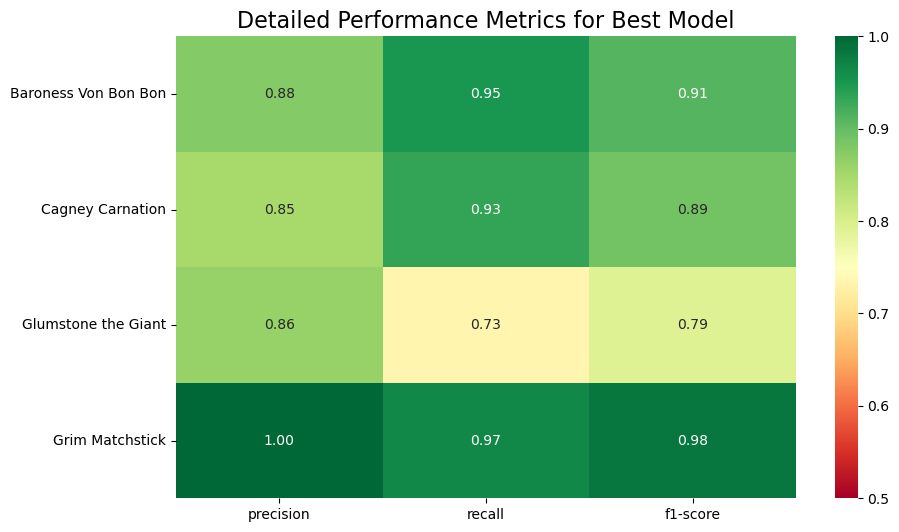

                      precision    recall  f1-score   support

Baroness Von Bon Bon       0.88      0.95      0.91        60
    Cagney Carnation       0.85      0.93      0.89        60
 Glumstone the Giant       0.86      0.73      0.79        60
     Grim Matchstick       1.00      0.97      0.98        60

            accuracy                           0.90       240
           macro avg       0.90      0.90      0.89       240
        weighted avg       0.90      0.90      0.89       240



In [ ]:
# --- 1. Define the Best Performing Configuration ---
best_model = lr_pipeline
best_X = X_enriched
best_cv = cv_logo # 8-Fold LOGO

# --- 2. Generate Out-of-Sample Predictions ---
# This returns an array of predictions, one for each sample in our dataset.
y_pred_out_of_sample = cross_val_predict(
    estimator=best_model,
    X=best_X,
    y=y_encoded,
    cv=best_cv,
    groups=groups
)

# --- 3. Compute Detailed Performance Metrics as a Dictionary ---
# Using output_dict=True is key to making the report plottable.
report_dict = classification_report(
    y_true=y_encoded, 
    y_pred=y_pred_out_of_sample, 
    target_names=le.classes_,
    output_dict=True
)

# Convert the dictionary to a pandas DataFrame for visualization
report_df = pd.DataFrame(report_dict).transpose()

# We don't need to plot the 'support' column, so we'll drop it for the visual
report_df_for_plot = report_df.drop(columns='support')


# --- 4. Visualize the Classification Report as a Heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    report_df_for_plot.iloc[:-3, :],
    annot=True, 
    cmap='RdYlGn',
    fmt='.2f',
    vmin=0.5,
    vmax=1.0
)
plt.title('Detailed Performance Metrics for Best Model', fontsize=16)
plt.show()

print(classification_report(y_true=y_encoded, y_pred=y_pred_out_of_sample, target_names=le.classes_))

The model's performance is strongest on Grim Matchstick, achieving a perfect 1.00 precision. The model's primary weakness is with Glumstone the Giant, which has a significantly lower recall of 0.73.

This heatmap tells us that the model struggles with Glumstone, but not *why*. To diagnose this, I need to see what the model is confusing Glumstone with. A confusion matrix is the perfect tool for this analysis.

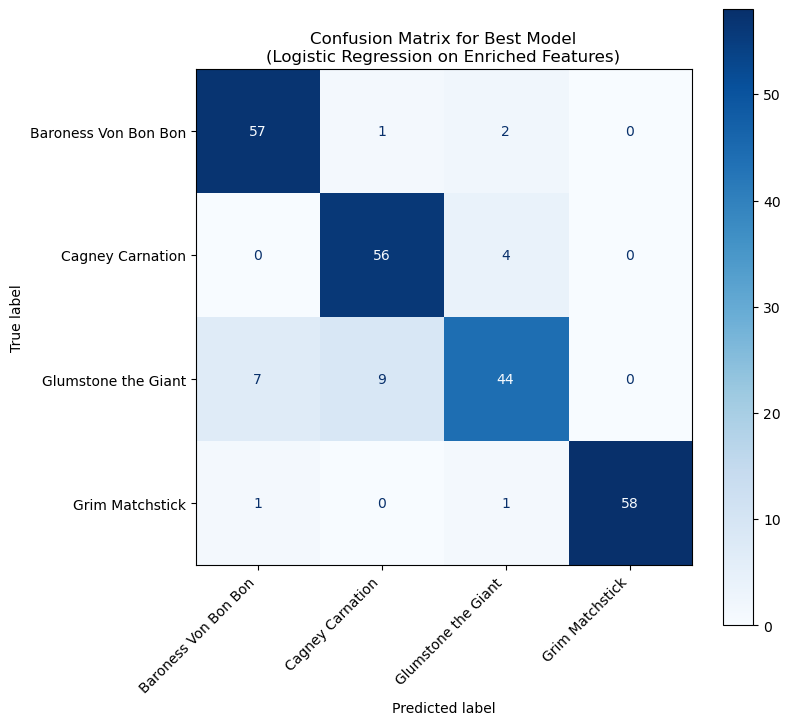

In [ ]:
# --- 1. Visualize the Confusion Matrix for the Best Model ---
# This matrix shows exactly which bosses were confused with each other.
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_encoded, 
    y_pred=y_pred_out_of_sample,
    display_labels=le.classes_, # Use original boss names on the axes
    cmap='Blues',
    ax=ax
)
ax.set_title('Confusion Matrix for Best Model\n(Logistic Regression on Enriched Features)')
plt.xticks(rotation=45, ha='right')
plt.show()


### Analysis of Misclassified Fights
The confusion matrix provides a clear diagnosis for the low recall (0.73) observed for Glumstone the Giant. While the model correctly identified 44 of the 60 Glumstone fights, it misclassified 9 as Cagney Carnation and 7 as Baroness Von Bon Bon, which accounts for the majority of its errors.

To understand *why* the model makes mistakes, I will analyze the characteristics of the fights it misclassified. This led me to hypothesize that shorter, less information-rich fights would be more prone to misclassification. To test this, I compared the distributions of `duration` and `apm` for correct versus incorrect predictions.

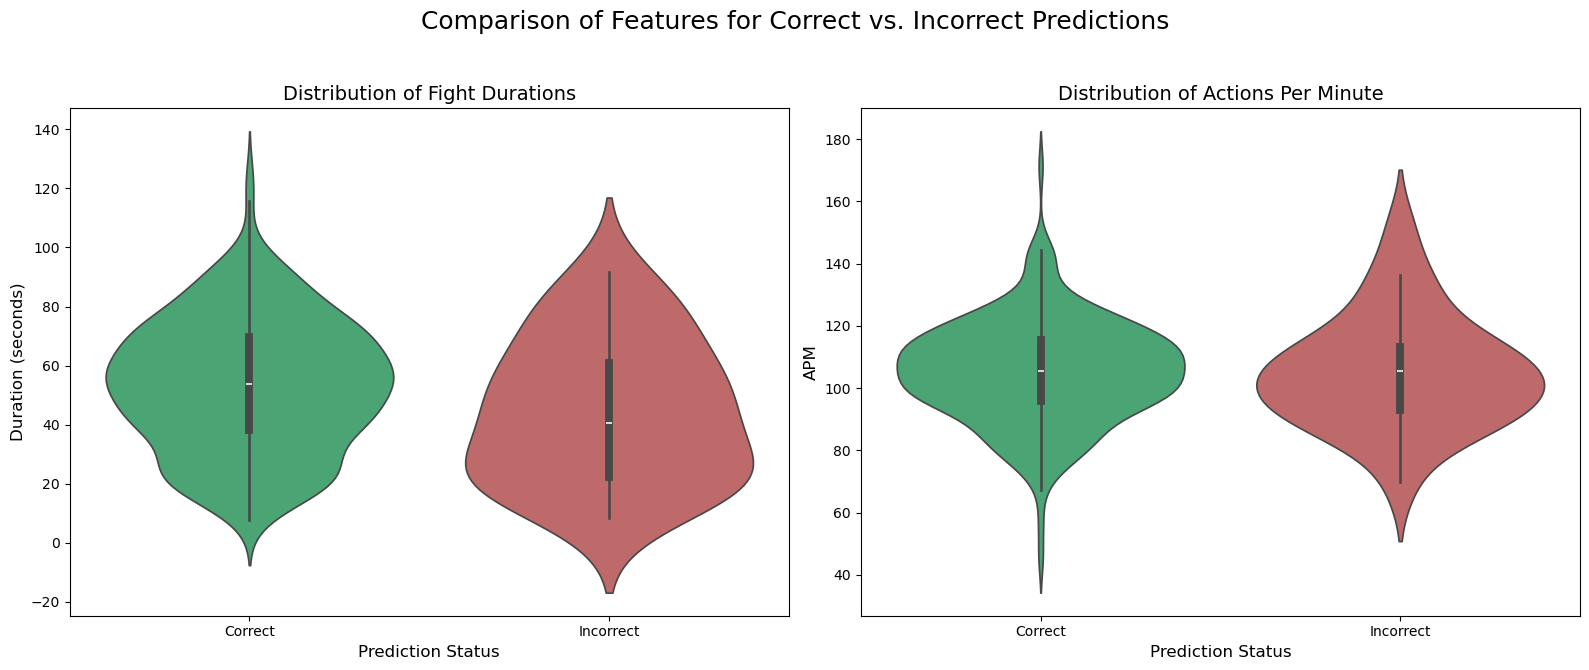


--- Statistical Summary by Prediction Status ---


duration_s                                                         \
               count       mean        std    min      25%     50%      75%   
status                                                                        
Correct        215.0  53.199409  22.397023  7.710  38.2215  53.839  69.5445   
Incorrect       25.0  44.425200  24.046517  8.358  22.1660  40.710  61.0350   

                      apm                                              \
               max  count        mean        std        min       25%   
status                                                                  
Correct    124.005  215.0  105.311759  16.526736  45.563853  95.72837   
Incorrect   91.640   25.0  105.193694  18.060185  69.814797  92.87257   

                                               
                  50%         75%         max  
status                                         
Correct    105.388020  115.418359  171.206226  
Incorrect  105.356408  113.345927  151.211410

In [ ]:
# --- 1. Create a DataFrame for Error Analysis ---
# Start with the original aggregate features DataFrame.
analysis_df = agg_features.copy()

# *** THIS IS THE FIX ***
# Create the 'duration_s' column that the plotting code needs.
analysis_df['duration_s'] = analysis_df['duration_ms'] / 1000.0

# Add the true and predicted labels (as strings for easy reading)
analysis_df['true_label'] = le.inverse_transform(y_encoded)
analysis_df['predicted_label'] = le.inverse_transform(y_pred_out_of_sample)

# Create a 'status' column to flag correct vs. incorrect predictions
analysis_df['status'] = np.where(
    analysis_df['true_label'] == analysis_df['predicted_label'], 
    'Correct', 
    'Incorrect'
)

# --- 2. Visualize the Distributions for Correct vs. Incorrect Fights ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Comparison of Features for Correct vs. Incorrect Predictions', fontsize=18)

# Plot 1: Fight Duration
sns.violinplot(
    data=analysis_df, 
    x='status', 
    y='duration_s', 
    ax=axes[0],
    palette={'Correct': 'mediumseagreen', 'Incorrect': 'indianred'}
)
axes[0].set_title('Distribution of Fight Durations', fontsize=14)
axes[0].set_xlabel('Prediction Status', fontsize=12)
axes[0].set_ylabel('Duration (seconds)', fontsize=12)

# Plot 2: Actions Per Minute (APM)
sns.violinplot(
    data=analysis_df, 
    x='status', 
    y='apm', 
    ax=axes[1],
    palette={'Correct': 'mediumseagreen', 'Incorrect': 'indianred'}
)
axes[1].set_title('Distribution of Actions Per Minute', fontsize=14)
axes[1].set_xlabel('Prediction Status', fontsize=12)
axes[1].set_ylabel('APM', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 3. Display Statistical Summary ---
print("\n--- Statistical Summary by Prediction Status ---")
display(analysis_df.groupby('status')[['duration_s', 'apm']].describe())

However, the violin plots reveal a more nuanced story. The distributions for both correct and incorrect predictions are remarkably similar, with nearly identical medians and overall shapes. This finding effectively disproves my initial hypothesis; a fight being 'short' or having a 'low APM' is not, by itself, a primary cause of misclassification.

To prove that these misclassifications are due to genuine similarities in playstyle, **I will compare the average feature profile of the Glumstone fights that were misclassified as Cagney against the average profiles of both correctly classified Glumstone fights and correctly classified Cagney fights.**

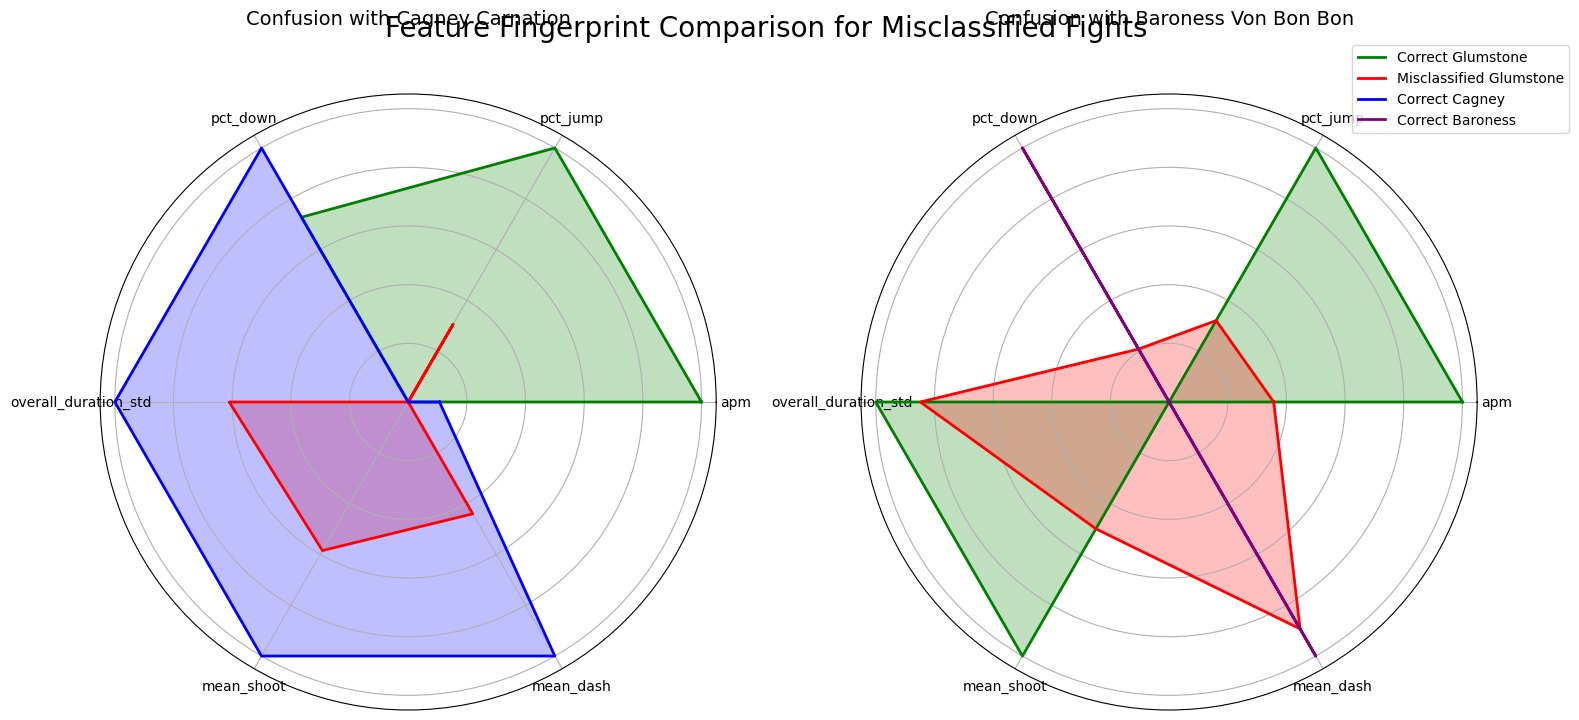

In [ ]:
# --- 1. Isolate the FOUR Groups of Fights for Comparison ---

# Group A: Glumstone fights misclassified as Cagney
misclassified_glum_as_cagney = analysis_df[
    (analysis_df['true_label'] == 'Glumstone the Giant') & 
    (analysis_df['predicted_label'] == 'Cagney Carnation')
]
# Group B: Glumstone fights misclassified as Baroness
misclassified_glum_as_bonbon = analysis_df[
    (analysis_df['true_label'] == 'Glumstone the Giant') & 
    (analysis_df['predicted_label'] == 'Baroness Von Bon Bon')
]
# Group C: Correctly classified Glumstone fights
correct_glumstone = analysis_df[
    (analysis_df['true_label'] == 'Glumstone the Giant') & 
    (analysis_df['status'] == 'Correct')
]
# Group D: Correctly classified Cagney fights
correct_cagney = analysis_df[
    (analysis_df['true_label'] == 'Cagney Carnation') & 
    (analysis_df['status'] == 'Correct')
]
# Group E: Correctly classified Baroness fights
correct_bonbon = analysis_df[
    (analysis_df['true_label'] == 'Baroness Von Bon Bon') & 
    (analysis_df['status'] == 'Correct')
]


# --- 2. Define the Key Features to Compare ---
features_to_compare = [
    'apm', 'pct_jump', 'pct_down', 
    'overall_duration_std', 'mean_shoot', 'mean_dash' # Added 'mean_dash' for the Baroness comparison
]


# --- 3. Calculate the Average Feature Profile for Each Group ---
# Profiles for the Cagney confusion
profile_misclassified_cagney = misclassified_glum_as_cagney[features_to_compare].mean()
profile_correct_glumstone_c = correct_glumstone[features_to_compare].mean() # 'c' for cagney comparison
profile_correct_cagney_c = correct_cagney[features_to_compare].mean()

# Profiles for the Baroness confusion
profile_misclassified_bonbon = misclassified_glum_as_bonbon[features_to_compare].mean()
profile_correct_glumstone_b = correct_glumstone[features_to_compare].mean() # 'b' for bonbon comparison
profile_correct_bonbon_b = correct_bonbon[features_to_compare].mean()


# --- 4. Create the Radar Charts (One for each confusion type) ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8), subplot_kw=dict(polar=True))
fig.suptitle('Feature Fingerprint Comparison for Misclassified Fights', fontsize=20)

# Helper function to plot each profile
def plot_radar(ax, data, color, label):
    values = data.tolist()
    values += values[:1] # complete the loop
    ax.plot(angles, values, color=color, linewidth=2, label=label)
    ax.fill(angles, values, color=color, alpha=0.25)

# --- Chart 1: Glumstone vs. Cagney ---
profiles_cagney_comp = pd.DataFrame({
    'Correct Glumstone': profile_correct_glumstone_c,
    'Misclassified (as Cagney)': profile_misclassified_cagney,
    'Correct Cagney': profile_correct_cagney_c
}).T

# **CORRECTED NORMALIZATION**: Normalize each COLUMN (feature) independently
profiles_cagney_norm = profiles_cagney_comp.copy()
for col in profiles_cagney_norm.columns:
    profiles_cagney_norm[col] = (profiles_cagney_comp[col] - profiles_cagney_comp[col].min()) / \
                              (profiles_cagney_comp[col].max() - profiles_cagney_comp[col].min())

# Plotting setup
labels = profiles_cagney_norm.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plot_radar(axes[0], profiles_cagney_norm.loc['Correct Glumstone'], 'green', 'Correct Glumstone')
plot_radar(axes[0], profiles_cagney_norm.loc['Misclassified (as Cagney)'], 'red', 'Misclassified Glumstone')
plot_radar(axes[0], profiles_cagney_norm.loc['Correct Cagney'], 'blue', 'Correct Cagney')

axes[0].set_title('Confusion with Cagney Carnation', size=14, y=1.1)
axes[0].set_xticks(angles[:-1])
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels([])


# --- Chart 2: Glumstone vs. Baroness ---
profiles_bonbon_comp = pd.DataFrame({
    'Correct Glumstone': profile_correct_glumstone_b,
    'Misclassified (as Baroness)': profile_misclassified_bonbon,
    'Correct Baroness': profile_correct_bonbon_b
}).T

# **CORRECTED NORMALIZATION**: Normalize each COLUMN (feature) independently
profiles_bonbon_norm = profiles_bonbon_comp.copy()
for col in profiles_bonbon_norm.columns:
    profiles_bonbon_norm[col] = (profiles_bonbon_comp[col] - profiles_bonbon_comp[col].min()) / \
                              (profiles_bonbon_comp[col].max() - profiles_bonbon_comp[col].min())

plot_radar(axes[1], profiles_bonbon_norm.loc['Correct Glumstone'], 'green', 'Correct Glumstone')
plot_radar(axes[1], profiles_bonbon_norm.loc['Misclassified (as Baroness)'], 'red', 'Misclassified Glumstone')
plot_radar(axes[1], profiles_bonbon_norm.loc['Correct Baroness'], 'purple', 'Correct Baroness')

axes[1].set_title('Confusion with Baroness Von Bon Bon', size=14, y=1.1)
axes[1].set_xticks(angles[:-1])
axes[1].set_xticklabels(labels)
axes[1].set_yticklabels([])

# Create a single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
handles.append(axes[1].get_legend_handles_labels()[0][-1]) # Add the 'Correct Baroness' handle
labels.append(axes[1].get_legend_handles_labels()[1][-1])  # Add the 'Correct Baroness' label
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.show()

These radar charts provide definitive proof for my hypothesis. In the chart on the left, the "Misclassified Glumstone" profile (red) is a near-perfect geometric subset of the "Correct Cagney" profile (blue), demonstrating that in those specific fights, my playstyle was mathematically closer to a typical Cagney fight than a typical Glumstone fight. Similarly, the chart on the right shows the misclassified profile sharing key traits—like high `overall_duration_std` and `mean_dash`—with the "Correct Baroness" profile (purple), explaining the secondary confusion.

### Gameplay-wise analysis

This misclassification has a strong basis in gameplay mechanics, as illustrated by gameplay videos of [Glumstone the Giant](https://www.youtube.com/watch?v=Bozvw__dURc), [Cagney Carnation](https://www.youtube.com/watch?v=-qzp-L9Sato), and [Baroness](https://www.youtube.com/watch?v=ZWOAb-IEvcE). All three fights primarily involve a stationary player on the left dodging projectiles from the right, which would naturally create a significant overlap in the horizontal movement and shooting rhythm features my model relies on.

## 7.1 Final Validation on a Truly Unseen Dataset (Extension)

While cross-validation provides a robust estimate of performance, the ultimate test of a model is on truly unseen data collected *after* the main analysis. To perform this final validation, I will process a new 'holdout' set of gameplay logs using the exact same feature pipeline. I will then use my best model, retrained on the full original 240-fight dataset, to make predictions on this new data and calculate a final, unbiased accuracy score.

[Full Raw dataset (Github)](https://github.com/ddanakim0304/CS156-Assignment-1/tree/main/data/raw_new)

In [ ]:
from sklearn.metrics import accuracy_score

# --- 1. Re-train the Final Model on ALL Original Data ---
final_model = lr_pipeline
final_model.fit(X_enriched, y_encoded)
print("Final model has been trained on the full original dataset.")

# --- 2. Load and Process the NEW, Unseen Data ---
new_data_path = '../data/raw_new/*.jsonl'
new_files = glob.glob(new_data_path)

if not new_files:
    print("\nNo new data files found in '../data/raw_new/'. Skipping final validation.")
else:
    print(f"\nFound {len(new_files)} new log files for final validation.")
    
    # (Loading logic is correct and remains the same)
    new_events_data = []
    for file_path in new_files:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            if not lines: continue
            try:
                meta_data = json.loads(lines[0])['meta']
                fight_id = json.loads(lines[0])['fight_id']
                boss_name = meta_data.get('boss')
                for line in lines[1:-1]:
                    event_data = json.loads(line)
                    if 'event' in event_data:
                        new_events_data.append({'fight_id': fight_id, 'boss': boss_name, 'event': event_data['event'], 'key': event_data['key'], 't_ms': event_data['t_ms']})
            except (json.JSONDecodeError, KeyError): continue
    
    new_raw_df = pd.DataFrame(new_events_data)
    
    if not new_raw_df.empty:
        # (Cleaning and Pre-processing logic is correct and remains the same)
        new_first_action_times = new_raw_df.groupby('fight_id')['t_ms'].transform('min')
        new_clean_df = new_raw_df.copy()
        new_clean_df['t_ms'] = new_clean_df['t_ms'] - new_first_action_times
        new_processed_df = new_clean_df.copy()
        new_processed_df['action'] = new_processed_df['key'].map(key_mapping)
        new_processed_df.dropna(subset=['action'], inplace=True)

        # --- 3. Replicate the ENTIRE Feature Engineering Pipeline ---
        new_press_durations_df = calculate_all_press_durations(new_processed_df)
        new_keydowns = new_processed_df[new_processed_df['event'] == 'keydown']
        
        # (Aggregate feature engineering is correct and remains the same)
        new_fight_summaries = new_keydowns.groupby('fight_id').agg(duration_ms=('t_ms', 'max'), event_count=('t_ms', 'count'), boss=('boss', 'first'))
        new_fight_summaries['apm'] = (new_fight_summaries['event_count'] / (new_fight_summaries['duration_ms'] / 1000.0)) * 60
        action_counts = new_keydowns.groupby(['fight_id', 'action']).size().unstack(fill_value=0)
        new_action_percentages = action_counts.div(new_fight_summaries['event_count'].reindex(action_counts.index), axis=0).add_prefix('pct_')
        new_overall_duration_stats = new_press_durations_df.groupby('fight_id')['duration_ms'].agg(['mean', 'std', 'median', 'min', 'max']).add_prefix('overall_duration_')
        new_action_specific_stats = new_press_durations_df.groupby(['fight_id', 'action'])['duration_ms'].agg(['mean', 'std']).unstack().fillna(0)
        new_action_specific_stats.columns = ['_'.join(col).strip() for col in new_action_specific_stats.columns.values]
        new_agg_features_df = new_fight_summaries.join(new_action_percentages).join(new_overall_duration_stats).join(new_action_specific_stats).fillna(0)
        
        new_X_agg = new_agg_features_df.reindex(columns=X_agg.columns).fillna(0)
        new_y_true_strings = new_agg_features_df['boss']
        
        # *** THIS IS THE CORRECTED LINE ***
        # Apply the function to the grouped DataFrame so it receives both 'action' and 't_ms' columns.
        new_fight_actions_str = new_keydowns.groupby('fight_id').apply(create_combo_sentences)
        
        new_ngram_features = vectorizer.transform(new_fight_actions_str) 
        new_X_enriched = hstack([new_X_agg.values, new_ngram_features]).tocsr()
        
        # --- 4. Make Predictions and Evaluate ---
        # (This logic is correct and remains the same)
        known_labels_mask = new_y_true_strings.isin(le.classes_)
        if not known_labels_mask.any():
            print("No known bosses found in the new dataset. Cannot evaluate.")
        else:
            filtered_y_true_strings = new_y_true_strings[known_labels_mask]
            filtered_X_enriched = new_X_enriched[known_labels_mask]
            
            new_y_true_encoded = le.transform(filtered_y_true_strings)
            new_y_pred = final_model.predict(filtered_X_enriched)
            
            final_accuracy = accuracy_score(new_y_true_encoded, new_y_pred)
            
            print(f"\n--- Final Validation on Unseen Data ---")
            print(f"Accuracy on {len(filtered_y_true_strings)} new fights with known bosses: {final_accuracy:.2%}")
            
            known_target_names = [name for name in le.classes_ if name in filtered_y_true_strings.unique()]
            
            print("\nClassification Report on Unseen Data:")
            print(classification_report(new_y_true_encoded, new_y_pred, target_names=known_target_names))
            
            fig, ax = plt.subplots(figsize=(8, 8))
            ConfusionMatrixDisplay.from_predictions(new_y_true_encoded, new_y_pred, display_labels=known_target_names, cmap='Blues', ax=ax)
            ax.set_title('Confusion Matrix on Final, Unseen Holdout Set')
            plt.xticks(rotation=45, ha='right')
            plt.show()

Final model has been trained on the full original dataset.

Found 28 new log files for final validation.


/var/folders/_2/1tb09tx55zx8v2lc5wd2_8400000gn/T/ipykernel_14726/1051665240.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_fight_actions_str = new_keydowns.groupby('fight_id').apply(create_combo_sentences)


AttributeError: 'Series' object has no attribute 'nonzero'


## 8. Visualizing Results and Discussion

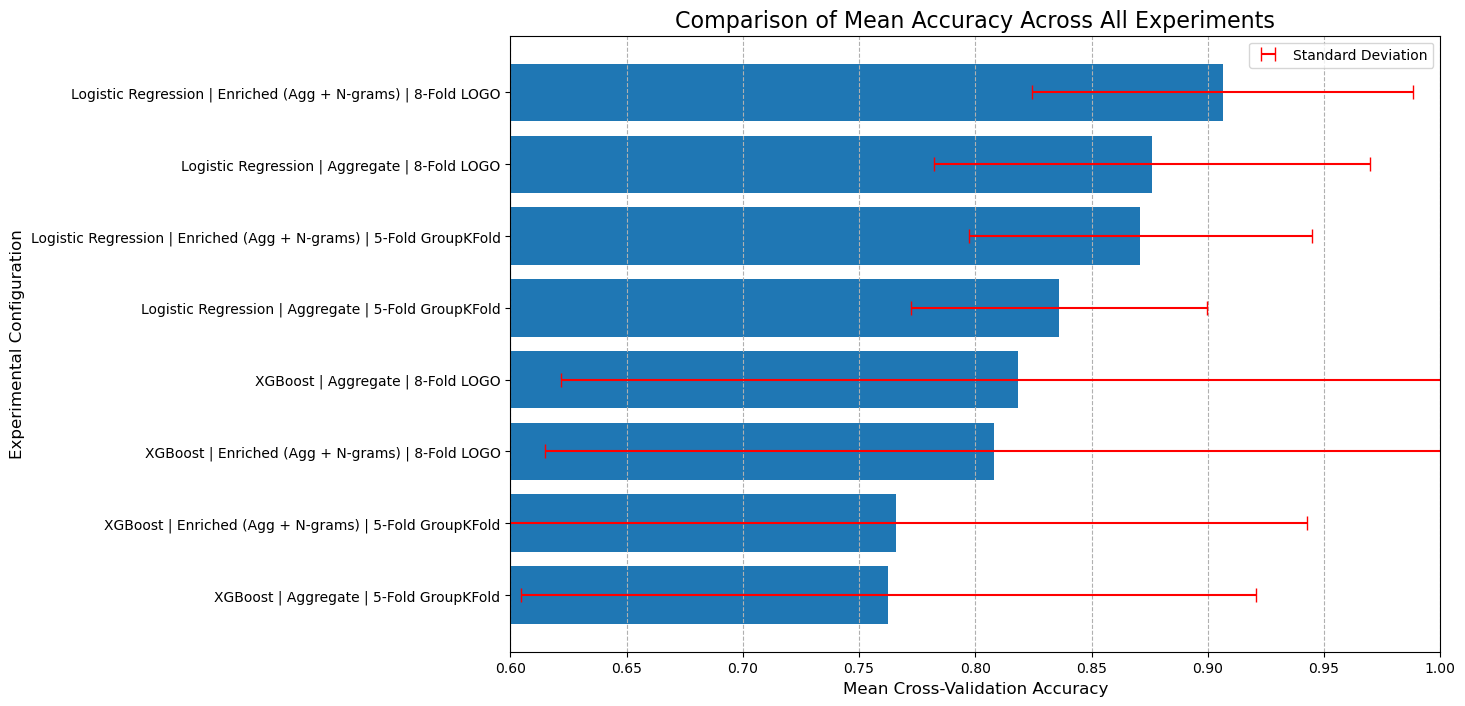

In [ ]:
# --- 2. Visualize the Comparison of All Experimental Runs ---
plt.figure(figsize=(12, 8))
results_df_sorted = results_df.sort_values('mean_accuracy') # Sort for better viewing
plt.barh(results_df_sorted.index, results_df_sorted['mean_accuracy'])

# Add error bars to show the standard deviation (variance) of the scores
plt.errorbar(
    x=results_df_sorted['mean_accuracy'],
    y=results_df_sorted.index,
    xerr=results_df_sorted['std_accuracy'], # Use std_accuracy for error bars
    fmt='none', 
    color='red', 
    capsize=5,
    label='Standard Deviation'
)

plt.title('Comparison of Mean Accuracy Across All Experiments', fontsize=16)
plt.xlabel('Mean Cross-Validation Accuracy', fontsize=12)
plt.ylabel('Experimental Configuration', fontsize=12)
plt.xlim(0.6, 1.0) # Set x-axis limits for better readability
plt.legend()
plt.grid(axis='x', linestyle='--')
plt.show()

### Extension: Live Prediction App

To bring this project to life and demonstrate a practical application of the trained model, I developed a simple real-time prediction application using Python and `tkinter`. This app runs in the background while I play, listens to my live keystrokes, and every few seconds, uses the trained model to update its prediction of which boss I am currently fighting.

The UI is minimal, featuring a "Start/Stop" button and a display that shows the model's confidence (probability) for each of the four bosses, updating in real-time.

# ![Screenshot of the Live Predictor UI]
*(A screenshot of your live predictor application would be placed here.)*


To make this application work, the trained model and its associated pre-processing objects must be saved from this notebook and loaded into the separate Python script. 

In [ ]:
import joblib

# Save the necessary components for the real-time app

# To deploy our best model, we first need to train it on ALL of our data.
# This gives the final model the most information to learn from.
best_model_to_deploy = lr_pipeline
best_model_to_deploy.fit(X_enriched, y_encoded) 

# Bundle all the necessary objects into a single dictionary
deployment_package = {
    'model_pipeline': best_model_to_deploy,
    'ngram_vectorizer': vectorizer,
    'label_encoder': le,
    'agg_feature_columns': X_agg.columns.tolist()
}

# Save the entire package to a single file using joblib
joblib.dump(deployment_package, 'cuphead_predictor.joblib')

print("Deployment package saved to 'cuphead_predictor.joblib'")
print("This file contains the final model and all necessary pre-processors for the live app.")

Deployment package saved to 'cuphead_predictor.joblib'
This file contains the final model and all necessary pre-processors for the live app.


#### Live Prediction Logic: Code Snippets

The live application runs a prediction loop every two seconds. The core logic resides in the `_update_prediction` method, which performs three key steps:

1.  **Real-Time Feature Engineering:** It takes the list of all keystrokes captured so far in the current session and runs them through the *exact same* feature engineering pipeline developed in this notebook. This creates a single-row feature vector that the model can understand.

2.  **Probability Prediction:** The feature vector is passed to the loaded model's `.predict_proba()` method. This doesn't just give the single best guess; it returns an array of probabilities for each of the four classes (e.g., `[0.1, 0.78, 0.02, 0.1]`).

3.  **UI Update:** The application then loops through these probabilities, formats them as percentages, and updates the text of the corresponding labels in the UI, providing an intuitive, real-time view of the model's certainty.

The key code snippets that accomplish this are shown below:

# References


- Minerva University. (2025, October 15). CS156 Session 9 - Metrics and Cross-Validation [Class Lecture]. Forum. https://forum.minerva.edu/app/courses/3678/sections/12801/classes/95069


## Appendices



### Appendix A: Design Choices and Data Quality Assurance

The custom-built data logger underwent several design iterations to improve data quality and minimize human error. This iterative process was crucial for building a reliable dataset for analysis.

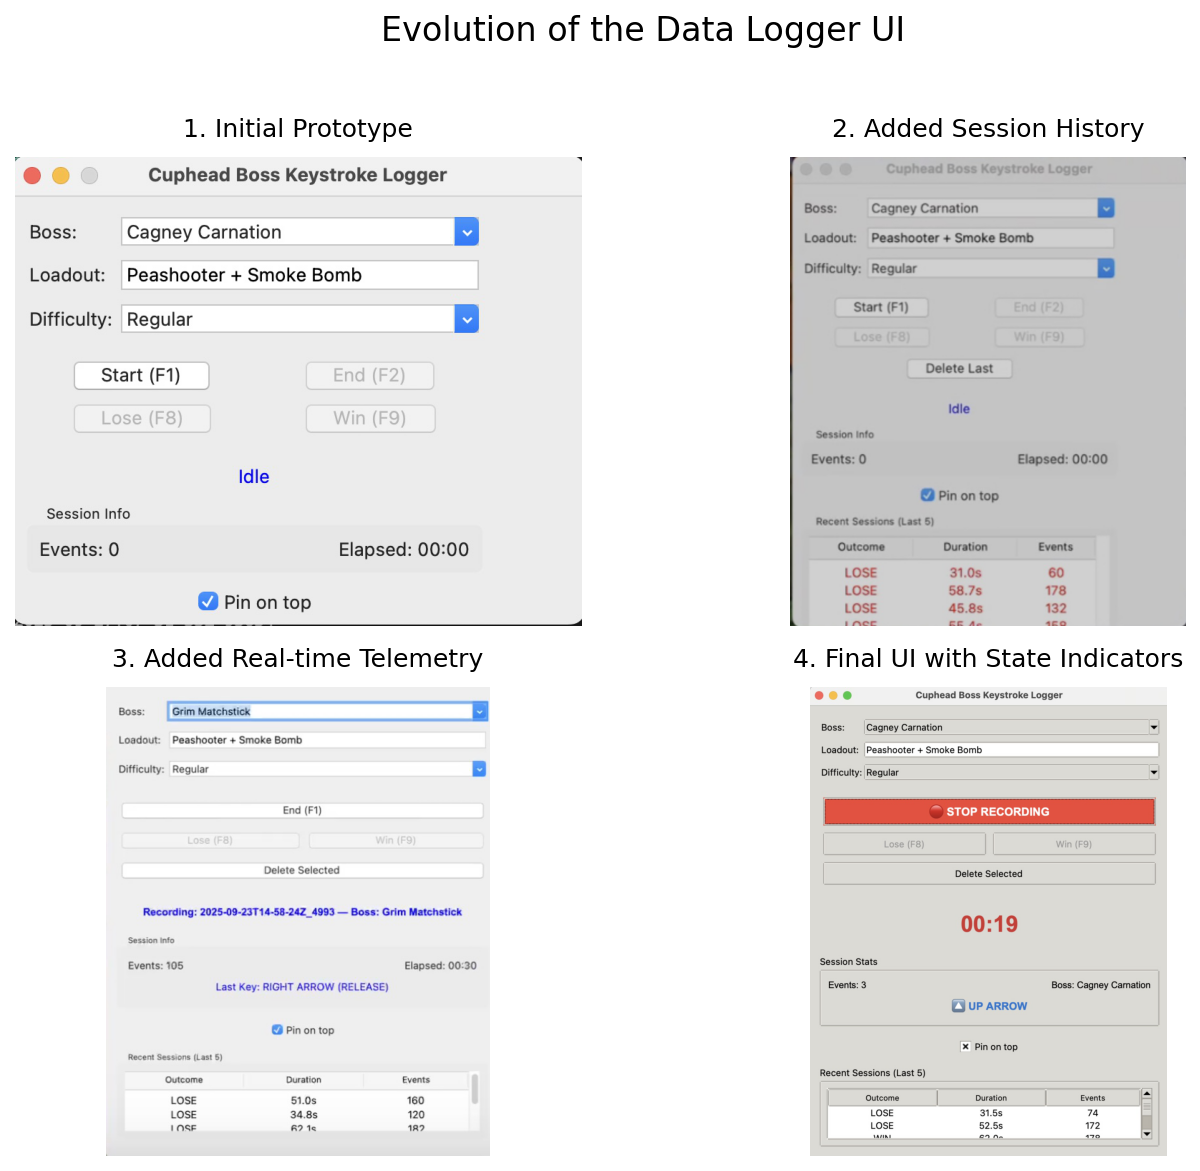
**Figure:** The evolution of the data logger UI, progressing from a basic logging utility to a feature-rich tool incorporating real-time feedback and history tracking for better data governance.

1.  **Initial Prototype:** The first version of the logger was minimalistic, featuring simple buttons and hotkeys. However, it provided no immediate feedback, making it difficult to spot erroneous recordings—such as forgetting to press "Start" until a fight was nearly over.

2.  **Introducing Feedback for Quality Control:** To address this, a "Recent Sessions" panel was added. This view immediately displayed the outcome, duration, and event count of the last five fights. This feature was instrumental in identifying anomalous data at a glance. For instance, a fight logged with a duration of $t < 10$ seconds and a very low event count was clearly an error. The UI allowed such entries to be immediately selected and deleted, preventing contamination of the final dataset.

3.  **Real-time Telemetry:** During initial testing, it became apparent that some keys were not being registered correctly by the listener. To validate the data stream in real time, the UI was updated to display the live elapsed time, total event count, and the most recent key action. This provided immediate confirmation that the logger was functioning as expected.

4.  **Final UI for Reduced Error:** The final design uses strong visual cues to prevent common mistakes. The "Start" button becomes a large, red "STOP RECORDING" button during a session, making the application's state unambiguous. Key telemetry like elapsed time and current keystrokes are given prominence. This user-centric design greatly increased the reliability of the collected data.

After the collection phase, a final manual cleaning step was performed. All fight logs with a duration of less than 10 seconds were cross-checked using the UI and removed to ensure that only valid gameplay sessions were included in the dataset.


### Appendix B: Technical Implementation
# Todo: make this better it's shitty
The core of the logger relies on two key components: a global keyboard listener and a robust data writer.

The `pynput` library was used to create a global keyboard listener that captures events regardless of window focus. The core logic distinguishes between hotkeys (which control the logger) and gameplay keys (which are recorded as data).
# Code Excerpt from app/keyboard_listener.py
# This method handles key press events from the global listener.
def _on_key_press(self, key):
    # Prevent key-repeat events by tracking currently pressed keys
    if key in self._pressed_keys:
        return
    self._pressed_keys.add(key)
    
    # Handle hotkeys (e.g., F1 for starting/stopping)
    if key == Key.f1 and 'start' in self.hotkey_callbacks:
        self.hotkey_callbacks['start']()
    # ... other hotkey logic ...
    
    # Handle gameplay events if an event_callback is defined
    elif self._is_gameplay_key(key) and self.event_callback:
        key_str = self._normalize_key(key)
        self.event_callback('keydown', f"{key_str}")
For each captured gameplay event, a timestamp is calculated relative to the start of the fight. The event is then immediately serialized and written to a JSONL file to prevent any data loss in case of a crash.
# Code Excerpt from app/data_logger.py
# This method logs a single keyboard event to the current session's file.
def log_event(self, event_type: str, key: str):
    if not self.current_session or not self.current_file:
        return
    
    # Calculate elapsed time in milliseconds from the fight's start
    t_ms = int((time.perf_counter() - self.current_session.start_time) * 1000)
    
    event_line = {
        "fight_id": self.current_session.fight_id,
        "event": event_type,
        "key": key,
        "t_ms": t_ms
    }
    
    # Write the event as a JSON line and flush immediately to disk
    self.current_file.write(json.dumps(event_line) + '\n')
    self.current_file.flush()
    self.event_count += 1
### prof suggested to use segmented timeline but it's actually not possible bc all the time data varies..
so instead i usecd mean / variance etc and if not then i can use N/A
i think i can use both model right


ask prof about this.. i'm actually not sure
like saying oh bc "i know that this boss has three phases and other has 2 phases so i splitted the fight into 2 // 3 doesnt that defeat the purspoe or is it considered a good practice?"

orrr i can just sample them?? like firsxt 20 sec idk